In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
import glob
import re
import seaborn as sns
from tqdm.notebook import tqdm
from collections import Counter
from scipy.stats import pearsonr

import sys
sys.path.append("..")
from data_preparation.data_preparation_pos import read_conll, ABSATokenizer
import utils.utils as utils
import utils.pos_utils as pos_utils

## PoS

In [2]:
def pos_word_split_freq(info, output, tokenizer):
    lang_name = info["lang_name"]
    file_path = info["file_path"]
    dataset = info["dataset"]
    
    if dataset == "test":
        conll_data = read_conll(file_path)
        words = np.array(conll_data[1]).flatten().sum()
        tags = np.array(conll_data[2]).flatten().sum()
        tokens, prop_tags, ids = tokenizer.subword_tokenize(words, tags)
        
        # Look for repeated ids
        counts = Counter(ids)
        split_word_ids = [key for key, value in counts.items() if counts[key] > 1]
        n_subwords = list(map(counts.get, split_word_ids))
        
        output[lang_name] = {"split_word_%": len(split_word_ids) / len(ids) * 100,
                             "avg_subwords_per_split": sum(n_subwords) / len(split_word_ids)}
    return output

In [116]:
tokenizer = ABSATokenizer.from_pretrained("bert-base-multilingual-cased")
split_stats = utils.run_through_data("../data/ud/", pos_word_split_freq, table={}, tokenizer=tokenizer)

In [117]:
split_stats_table = utils.order_table(pd.DataFrame(split_stats).T.reset_index().rename(columns={"index": "Language"}))

In [118]:
split_stats_table

,Language,split_word_%,avg_subwords_per_split
0,Bulgarian,22.608339,3.044327
1,English,9.207182,2.429653
2,Russian,20.617642,3.073314
3,Slovak,24.782001,3.050724
4,Croatian,24.562258,2.780663
5,Chinese,30.487660,2.191359
6,Vietnamese,20.263443,2.386465
7,Thai,24.788258,3.737056
8,Finnish,24.487259,3.171380
9,Basque,28.017709,2.717466


Export excel

In [53]:
split_stats_table.to_excel("pos_split_word_stats.xlsx", index=False)

Export latex

In [108]:
split_stats_table[["split_word_%", "avg_subwords_per_split"]] = split_stats_table[["split_word_%", 
                                                                                   "avg_subwords_per_split"]].applymap(
    lambda x: "{:.2f}".format(x)
)

In [109]:
utils.convert_table_to_latex(split_stats_table)

\fusional{Fusional} & Bulgarian & 22.61 & 3.04\\
\fusional{Fusional} & English & 9.21 & 2.43\\
\fusional{Fusional} & Russian & 20.62 & 3.07\\
\fusional{Fusional} & Slovak & 24.78 & 3.05\\
\fusional{Fusional} & Croatian & 24.56 & 2.78\\
\isolating{Isolating} & Chinese & 30.49 & 2.19\\
\isolating{Isolating} & Vietnamese & 20.26 & 2.39\\
\isolating{Isolating} & Thai & 24.79 & 3.74\\
\agglutinative{Agglutinative} & Finnish & 24.49 & 3.17\\
\agglutinative{Agglutinative} & Basque & 28.02 & 2.72\\
\agglutinative{Agglutinative} & Japanese & 23.81 & 2.51\\
\agglutinative{Agglutinative} & Korean & 29.46 & 2.71\\
\agglutinative{Agglutinative} & Turkish & 25.56 & 2.91\\
\introflexive{Introflexive} & Arabic & 22.49 & 2.90\\
\introflexive{Introflexive} & Hebrew & 25.97 & 2.82\\


,group,Language,split_word_%,avg_subwords_per_split
0,\fusional{Fusional},Bulgarian,22.61,3.04
1,\fusional{Fusional},English,9.21,2.43
2,\fusional{Fusional},Russian,20.62,3.07
3,\fusional{Fusional},Slovak,24.78,3.05
4,\fusional{Fusional},Croatian,24.56,2.78
5,\isolating{Isolating},Chinese,30.49,2.19
6,\isolating{Isolating},Vietnamese,20.26,2.39
7,\isolating{Isolating},Thai,24.79,3.74
8,\agglutinative{Agglutinative},Finnish,24.49,3.17
9,\agglutinative{Agglutinative},Basque,28.02,2.72


### Plots

In [119]:
lang_to_group = utils.make_lang_group_dict()

In [120]:
split_stats_table.insert(0, "Group", split_stats_table["Language"].apply(lambda x: lang_to_group[x]))

In [121]:
wiki = pd.read_excel("all_wiki_sizes.xlsx")

In [122]:
wiki["Articles"] = wiki["Articles"].astype(str).apply(lambda x: x.replace(",", "").replace(".", "")).astype(int)

In [123]:
split_stats_table = pd.merge(split_stats_table, wiki[["Language", "Articles"]], how="left", on="Language")

In [124]:
split_stats_table.head()

,Group,Language,split_word_%,avg_subwords_per_split,Articles
0,Fusional,Bulgarian,22.608339,3.044327,266577
1,Fusional,English,9.207182,2.429653,6180875
2,Fusional,Russian,20.617642,3.073314,1671117
3,Fusional,Slovak,24.782001,3.050724,234758
4,Fusional,Croatian,24.562258,2.780663,223035


In [146]:
split_stats_table["log_Articles"] = np.log10(split_stats_table["Articles"])

In [147]:
pearsonr(x=split_stats_table["Articles"], y=split_stats_table["split_word_%"])

(-0.8371493392310339, 9.901851497217945e-05)

In [148]:
pearsonr(x=split_stats_table["Articles"][split_stats_table["Language"] != "English"], 
         y=split_stats_table["split_word_%"][split_stats_table["Language"] != "English"])

(-0.35237548656268874, 0.21658548650619913)

In [149]:
pearsonr(x=split_stats_table["log_Articles"][split_stats_table["Language"] != "English"], 
         y=split_stats_table["split_word_%"][split_stats_table["Language"] != "English"])

(-0.23458447410453942, 0.41951685284312396)

In [150]:
pearsonr(x=split_stats_table["Articles"][~split_stats_table["Language"].isin(["English", "Chinese"])], 
         y=split_stats_table["split_word_%"][~split_stats_table["Language"].isin(["English", "Chinese"])])

(-0.6272523291810979, 0.021747993886614775)

In [151]:
sns.set()
sns.set_style("ticks")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rcParams["text.usetex"] = True

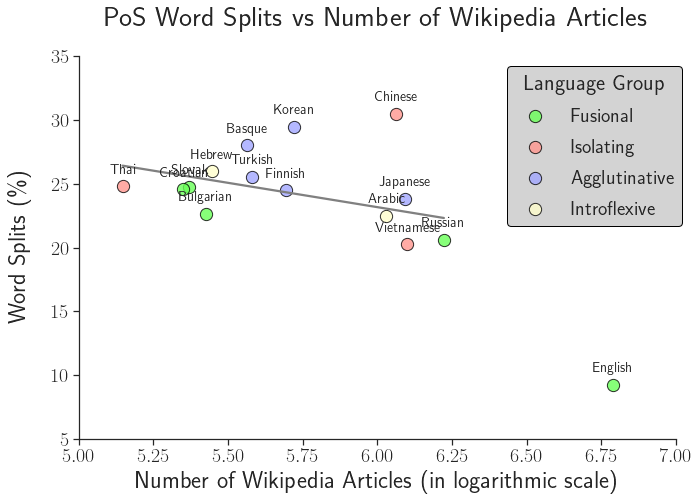

In [158]:
colors = {"Fusional": "#95c78f", 
          "Isolating": "#f79d97", 
          "Agglutinative": "#abaff5", 
          "Introflexive": "#fffecc"}
colors = {k: sns.saturate(v) for k,v in colors.items()}
extra_fontsize = 0

g = sns.lmplot(x="log_Articles", y="split_word_%", data=split_stats_table, hue="Group", palette=colors,
               fit_reg=False, legend=False, height=6, aspect=1.5, scatter_kws={"s": 150, "edgecolors": "black"})
sns.regplot(x="log_Articles", y="split_word_%", 
            data=split_stats_table[~split_stats_table["Language"].isin(["English", "Chinese"])], 
            scatter=False, color="grey", ci=None, order=1)

for i, row in split_stats_table.iterrows():
    plt.text(row["log_Articles"], row["split_word_%"] + 1, row["Language"], fontsize=14, 
             horizontalalignment="center")

plt.legend(title="Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.7, 1), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.6)

plt.ylim((5,35))
plt.xlim((5,7))
plt.ylabel("Word Splits (\%)", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Number of Wikipedia Articles (in logarithmic scale)", fontsize=24 +  extra_fontsize)
plt.title("PoS Word Splits vs Number of Wikipedia Articles", fontsize=28 +  extra_fontsize, pad=30)
plt.tick_params(labelsize=20)

#plt.savefig("../data_exploration/plots/pos_word_splits_vs_wiki.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

Without logscale some get crammed

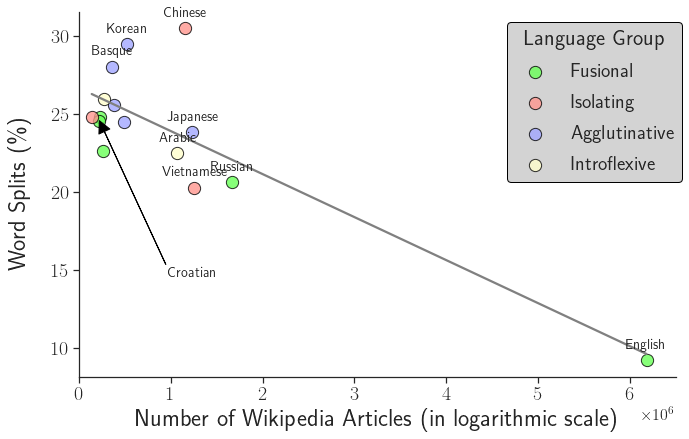

In [156]:
colors = {"Fusional": "#95c78f", 
          "Isolating": "#f79d97", 
          "Agglutinative": "#abaff5", 
          "Introflexive": "#fffecc"}
colors = {k: sns.saturate(v) for k,v in colors.items()}
extra_fontsize = 0

g = sns.lmplot(x="Articles", y="split_word_%", data=split_stats_table, hue="Group", palette=colors,
               fit_reg=False, legend=False, height=6, aspect=1.5, scatter_kws={"s": 150, "edgecolors": "black"})
sns.regplot(x="Articles", y="split_word_%", data=split_stats_table, 
            scatter=False, color="grey", ci=None, order=1)

for i, row in split_stats_table.iterrows():
    if row["Language"] not in ["Thai", "Turkish", "Finnish", "Bulgarian", "Croatian", "Slovak", "Hebrew"]:
        plt.text(row["Articles"], row["split_word_%"] + 0.75, row["Language"], fontsize=14, 
                 horizontalalignment="center")

plt.legend(title="Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.7, 1), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.6)

row = split_stats_table[split_stats_table["Language"] == "Croatian"]
plt.annotate("Croatian", (row["Articles"],row["split_word_%"]), fontsize=14, xytext=(row["Articles"]+1e6,row["split_word_%"]-10), 
             arrowprops={"width": 0.1, "color": "black"}, horizontalalignment="center")

# plt.ylim((5,35))
plt.xlim((0,6.5e6))
plt.ylabel("Word Splits (\%)", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Number of Wikipedia Articles (in logarithmic scale)", fontsize=24 +  extra_fontsize)
# plt.title("PoS Average Example Length \n vs Average Performance Over Language", fontsize=28 +  extra_fontsize, pad=30)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

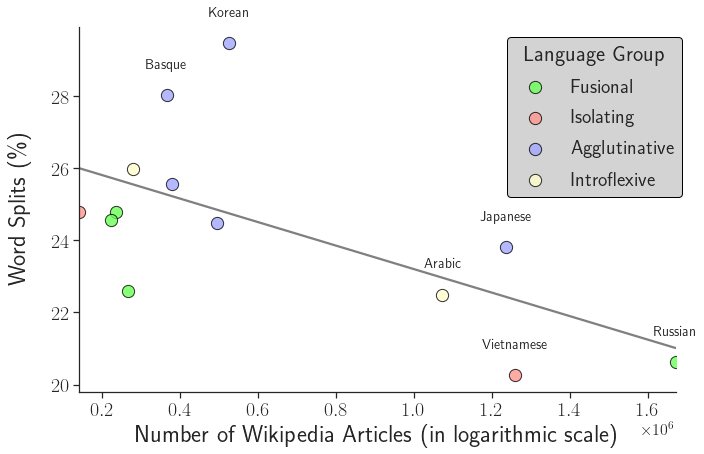

In [141]:
colors = {"Fusional": "#95c78f", 
          "Isolating": "#f79d97", 
          "Agglutinative": "#abaff5", 
          "Introflexive": "#fffecc"}
colors = {k: sns.saturate(v) for k,v in colors.items()}
extra_fontsize = 0

g = sns.lmplot(x="Articles", y="split_word_%", 
               data=split_stats_table[~split_stats_table["Language"].isin(["English", "Chinese"])], 
               hue="Group", palette=colors,
               fit_reg=False, legend=False, height=6, aspect=1.5, scatter_kws={"s": 150, "edgecolors": "black"})
sns.regplot(x="Articles", y="split_word_%", 
            data=split_stats_table[~split_stats_table["Language"].isin(["English", "Chinese"])], 
            scatter=False, color="grey", ci=None)

for i, row in split_stats_table[~split_stats_table["Language"].isin(["English", "Chinese"])].iterrows():
    if row["Language"] not in ["Thai", "Turkish", "Finnish", "Bulgarian", "Croatian", "Slovak", "Hebrew"]:
        plt.text(row["Articles"], row["split_word_%"] + 0.75, row["Language"], fontsize=14, 
                 horizontalalignment="center")

plt.legend(title="Language Group", title_fontsize=22 + extra_fontsize, loc="upper left", 
           bbox_to_anchor=(0.7, 1), fontsize=20 + extra_fontsize, facecolor="lightgrey", 
           framealpha=1, edgecolor="black", labelspacing=0.6)

# plt.ylim((5,35))
# plt.xlim((0,6.5e6))
plt.ylabel("Word Splits (\%)", fontsize=24 + extra_fontsize, labelpad=20)
plt.xlabel("Number of Wikipedia Articles (in logarithmic scale)", fontsize=24 +  extra_fontsize)
# plt.title("PoS Average Example Length \n vs Average Performance Over Language", fontsize=28 +  extra_fontsize, pad=30)
plt.tick_params(labelsize=20)

#plt.savefig("../results/plots/.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

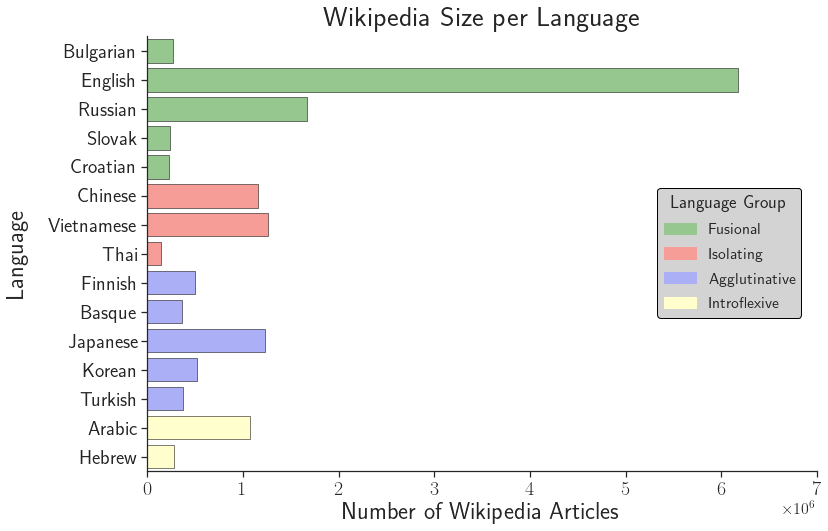

In [98]:
plt.figure(figsize=(12, 8))
colors = ["#95c78f"] * 5 + ["#f79d97"] * 3 + ["#abaff5"] * 5 + ["#fffecc"] * 2

ax = sns.barplot(data=split_stats_table, x="Articles", y="Language", palette=colors, saturation=1, ec="black", linewidth=0.5)

legend_patches = [Patch(color=color, label=label) for color, label in zip(["#95c78f", "#f79d97", "#abaff5", "#fffecc"],
                                                                          ["Fusional", "Isolating", "Agglutinative", 
                                                                           "Introflexive"])]
ax.legend(handles=legend_patches, title="Language Group", title_fontsize=18,
          loc="upper left", bbox_to_anchor=(0.75, 0.67), fontsize=16, facecolor="lightgrey", 
          framealpha=1, edgecolor="black", labelspacing=0.6)

plt.xlim((0,7e6))
plt.ylabel("Language", fontsize=24, labelpad=20)
plt.xlabel("Number of Wikipedia Articles", fontsize=24)
plt.title("Wikipedia Size per Language", fontsize=28, pad=10)
plt.tick_params(labelsize=20)

sns.despine(ax=ax)
#ax.figure.savefig("plots/wiki_size.pdf", dpi=400)